# Image Search on Brain MRI Scans

This example demonstrates how to store [brain scan images](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) as vector embeddings in KDB.AI, then how to search this dataset to instantly retrieve similar images.

Brain tumors are intricate due to variations in size and location, therefore understanding their nature is challenging. Professional neurosurgeons are essential for accurate MRI analysis, but in developing nations, the scarcity of skilled doctors and tumor knowledge results in time-consuming report generation from MRI scans. 

A potential solution lies in automated systems like vector database search, which could help alleviate this issue. Using semantic search, KDB.AI enables users to effectively retrieve the most similar scan images quickly even when the query and database content aren't an exact match, leveraging semantic context. 

### Aim 
In this tutorial, we'll walk through the process of storing images in a vector database, using a pre-trained neural network to generate data structures known as vector embeddings. We will use KDB.AI's vector database offering to find images with similar vector embeddings to an input query image. We will cover the following topics:

1. Load Image Data
1. Create Image Vector Embeddings
1. Store Embeddings in KDB.AI
1. Query the KDB.AI Table
1. Search For Similar Images To A Target Image
1. Delete the KDB.AI Table

---

## 0. Setup

### Import Packages

In [1]:
# download data
import os
from zipfile import ZipFile

In [ ]:
# embeddings
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
import pandas as pd
import ast

<div class="alert alert-block alert-warning">
<b>Getting a warning?</b><br/>
We can ignore the 'Could not find TensorRT' warning as it will not affect the code later on in the notebook.
</div>

In [3]:
# timing
from tqdm.auto import tqdm

In [4]:
# vector DB
import kdbai_client as kdbai
from getpass import getpass
import time

In [5]:
# plotting
from matplotlib import pyplot as plt

### Define Helper Functions

In [6]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

## 1. Load Image Data

### Dataset Overview

The dataset that will be used for this example is the [Brain Tumor Classification](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) images available on Kaggle. The dataset consist of images which are already split into Training and Testing folders.
Each folder has more four subfolders. These subfolders have MRIs corresponding to four different tumor classes: Glioma, Meningioma, Notumor, Pituitary.

### Extract Image Data From ZipFile

The dataset used in this sample comes from [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) and is 91MB when zipped. This file has been downloaded locally and saved in this repo to simplify the notebook execution process.

Here, we will extract the data from this zipped file using Python's `zipfile` package.
This will allow us to access the `Training` and `Testing` images in this dataset.

In [7]:
# Extract Zip file after uploading images (archive.zip folder from Kaggle)
def extract_zip(file_name: str) -> None:
    with ZipFile(file_name, "r") as zipf:
        zipf.extractall("data")

In [8]:
extract_zip("data/archive.zip")

You should now have two folders one called Training and one called Testing.

### Define List Of Paths To The Extracted Image Files

Next, let's extract image file paths from different subfolders within the 'Testing' directory. These are needed to pass to our function in the next section to create embeddings.

In [9]:
def extact_file_paths_from_folder(parent_dir: str) -> list:
    image_paths = []
    for sub_folder in os.listdir(parent_dir):
        sub_dir = os.path.join(parent_dir, sub_folder)
        image_paths += [os.path.join(sub_dir, file) for file in os.listdir(sub_dir)]
    return image_paths

In [10]:
training_paths = extact_file_paths_from_folder("data/Training/")
testing_paths = extact_file_paths_from_folder("data/Testing/")
testing_paths_glioma = [item for item in testing_paths if "glioma" in item]

## 2. Create Image Vector Embeddings 

<div class="alert alert-block alert-info">
<b>Time Saver</b><br/>
When it comes to embedding the data, there are two choices:

- A. Load in pre-embedded image embeddings and use these as your image vector embeddings   
- B. Create brand new image embeddings by loading in each image, processing it, and creating an embedding for each image

Creating new embedding takes between 5 and 20 mins, so the default code shown below will be to use pre-embedded data.
   
To create your own embeddings, comment out the code in the `Use Pre-Embedded Data` section and uncomment the code under the title `Create New Embeddings Using ResNet50` and run this.
</div>

### A. Use Pre-Embedded Data

In [11]:
# Define a custom function to convert strings to lists of floats
def parse_vectors(vectors_str):
    return ast.literal_eval(vectors_str)

In [12]:
# unzip pre-embedded data file
extract_zip("data/mri_embeddings.zip")

In [13]:
# Load the CSV files into pandas DataFrames
training_embeddings = pd.read_csv(
    "data/mri_training_embeddings.csv", converters={"vectors": parse_vectors}
)
testing_embeddings_glioma = pd.read_csv(
    "data/mri_testing_glioma_embeddings.csv", converters={"vectors": parse_vectors}
)

### B. Create New Embeddings Using ResNet50

We prepare image embeddings by loading images, applying preprocessing, and generating vector embeddings.
To create these image vector embeddings, we utilize the Python libraries `TensorFlow` and `Keras` to process image data using a pretrained [ResNet50](https://keras.io/api/applications/resnet/) model. These embeddings will be saved in four Pandas DataFrames for the different types of brain tumor images (Glioma, Meningioma, Notumor, Pituitary).

#### Why ResNet50?

ResNet50 is a deep neural network with 50 layers, allowing it to capture complex and hierarchical features in images. This depth enables it to learn intricate patterns present in medical images like MRI scans. It comes with pretrained weights on a large dataset (ImageNet), making it a valuable starting point for image analysis tasks.

#### Vector Generation Process Explained

We define our model and then create two functions which will do the work of creating our embeddings for us.
We will pass the lists of file paths created earlier to the `create_embeddings` function so it can iterate through each image path and iteratively call the `create_image_embedding` function to create each embedding.
The resulting embeddings are stored in a Pandas DataFrame along with the corresponding image path.
The `create_embeddings` function then combines the individual DataFrames for each image into a single DataFrame.
For simplicity we will only use the training images and one from the testing image folder (Glioma).

In [14]:
# model = ResNet50(include_top=False, weights="imagenet", pooling="avg")

In [15]:
# def create_image_embedding(model, img_path: str) -> pd.DataFrame:
#     img = image.load_img(img_path, target_size=(224, 224))
#     x = preprocess_input(
#         np.expand_dims(image.img_to_array(img), axis=0)
#     )
#     preds = model.predict(x)
#     return pd.DataFrame({"vectors": [preds[0].tolist()]})

In [16]:
# def create_embeddings(file_paths: list) -> pd.DataFrame:
#     embedding_df = pd.DataFrame()
#     for curr_img in tqdm(file_paths):
#         curr_df = create_image_embedding(model, curr_img)
#         curr_df["image"] = curr_img
#         embedding_df = pd.concat([embedding_df, curr_df], ignore_index=True)
#     return embedding_df

In [17]:
# training_embeddings = create_embeddings(training_paths)
# testing_embeddings_glioma = create_embeddings(testing_paths_glioma)

### Inspect Embedded Data

We can now take a look at these embeddings represented in a DataFrame.

In [19]:
show_df(training_embeddings)

(2870, 2)


,vectors,image
0,"[0.18114933371543884, 0.6230432987213135, 0.08...",data/Training/pituitary_tumor/p (403).jpg
1,"[0.1167869046330452, 0.6146861910820007, 0.188...",data/Training/pituitary_tumor/p (16).jpg
2,"[0.16823923587799072, 0.3355640769004822, 0.00...",data/Training/pituitary_tumor/p (697).jpg
3,"[0.063155397772789, 0.7972246408462524, 0.0213...",data/Training/pituitary_tumor/p (689).jpg
4,"[0.2886735498905182, 1.2778379917144775, 0.0, ...",data/Training/pituitary_tumor/p (445).jpg


## 3. Store Embeddings in KDB.AI

### Connect to KDB.AI Session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [20]:
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [21]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have two columns the first `image` with the file paths to the raw image files, the second will be the vector embeddings we created in the previous step. 

In [22]:
image_schema = {
    "columns": [
        {
            "name": "vectors",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "hnsw"},
        },
        {"name": "image", "pytype": "str"},
    ]
}

### Create Vector DB Table

Use the KDB.AI `create_table` function to create a table that matches the defined schema in the vector database.

In [23]:
# First ensure the table does not already exist
try:
    session.table("images").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [24]:
table = session.create_table("images", image_schema)

### Add Embedded Data to KDB.AI Table

When adding larger amounts of data, you should insert data into an index in chunks.

It is a good idea to first get an idea of how large the dataset to insert is.

In [25]:
training_embeddings.memory_usage(deep=True).sum() / (1024**2)  # Convert bytes to MB

50.145575523376465

This dataset 50MB, we can split it up to insert <10MB at a time using chunk size of 500.

In [26]:
CHUNK_SIZE = 500

In [27]:
for i in range((len(training_embeddings) - 1) // CHUNK_SIZE + 1):
    istart = i * CHUNK_SIZE
    iend = (i + 1) * CHUNK_SIZE
    table.insert(training_embeddings.iloc[istart:iend].reset_index(drop=True))

### Verify Data Has Been Inserted

Running `table.query()` should show us that data has been added.

In [29]:
show_df(table.query())

(2870, 2)


,vectors,image
0,"[0.18114933371543884, 0.6230432987213135, 0.08...",data/Training/pituitary_tumor/p (403).jpg
1,"[0.1167869046330452, 0.6146861910820007, 0.188...",data/Training/pituitary_tumor/p (16).jpg
2,"[0.16823923587799072, 0.3355640769004822, 0.00...",data/Training/pituitary_tumor/p (697).jpg
3,"[0.063155397772789, 0.7972246408462524, 0.0213...",data/Training/pituitary_tumor/p (689).jpg
4,"[0.2886735498905182, 1.2778379917144775, 0.0, ...",data/Training/pituitary_tumor/p (445).jpg


## 4. Query KDB.AI Table

Now that all the embeddings of the images are in KDB.AI's database, it's time to demonstrate KDB.AI's fast query capabilities.

The `query` function accepts a wide range of arguments to make it easy to filter, aggregate and sort. Run `table.query?` to see them all.

Let's demonstrate this by filtering for images that contain "glioma" in the filename.

In [30]:
table.query(filter=[("like", "image", "*glioma*")])

,vectors,image
0,"[0.7889169454574585, 0.07352933287620544, 0.0,...",data/Training/glioma_tumor/gg (607).jpg
1,"[0.0, 0.25540703535079956, 0.13116863369941711...",data/Training/glioma_tumor/gg (751).jpg
2,"[1.2045520544052124, 0.27882763743400574, 0.72...",data/Training/glioma_tumor/gg (117).jpg
3,"[0.6326215863227844, 2.248053550720215, 0.0100...",data/Training/glioma_tumor/gg (517).jpg
4,"[0.19425621628761292, 0.6182567477226257, 0.06...",data/Training/glioma_tumor/gg (327).jpg
...,...,...
821,"[0.7794908881187439, 1.2882121801376343, 0.557...",data/Training/glioma_tumor/gg (760).jpg
822,"[2.216350793838501, 0.09440609067678452, 1.341...",data/Training/glioma_tumor/gg (241).jpg
823,"[0.3796887695789337, 1.0229192972183228, 0.025...",data/Training/glioma_tumor/gg (382).jpg
824,"[0.11522512137889862, 0.37626102566719055, 0.0...",data/Training/glioma_tumor/gg (579).jpg


## 5. Search For Similar Images To A Target Image

Finally, let's perform similarity search on the images. We do this using the `search` function.

### Example Image

First let's select a random row from our test dataset and visualize. 

In the below code snippet we also extract the `vectors` column from that row and save it to variable `query_embedding` - this will be what we base our search on in the next section.

In [31]:
# Get a sample row
random_row_index = 10

In [32]:
# Select the random row and the desired column's value
random_row = testing_embeddings_glioma.iloc[random_row_index]
sample_embedding = [random_row["vectors"]]

In [33]:
# Visualization function
def plot_image(axis, source: str, label: str) -> None:
    axis.imshow(plt.imread(source))
    axis.axis("off")
    axis.set_title(f"{label}: {source}")

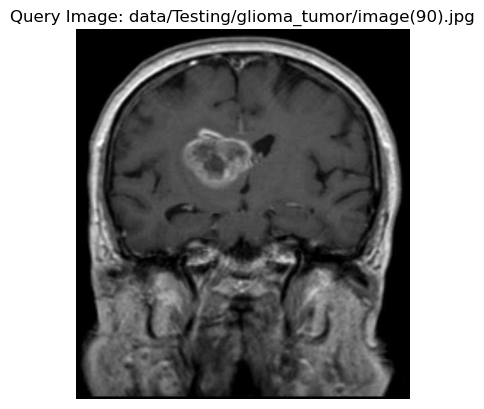

In [34]:
plot_image(plt.subplots()[-1], random_row["image"], "Query Image")

### Search Based on Sample Image

Using the the embeddings we extracted above in `sample_embedding` for this random image, we can search to get the three nearest neighbors to our query image using KDB.AI.

In a real life scenario, the sample images used to search would be ones selected by a doctor.

In [35]:
results = table.search(sample_embedding, n=3)
results[0]

,vectors,image,__nn_distance
0,"[0.23452340066432953, 1.1014717817306519, 0.12...",data/Training/meningioma_tumor/m2 (133).jpg,414.123291
1,"[0.25492748618125916, 1.1421271562576294, 0.62...",data/Training/meningioma_tumor/m2 (4).jpg,445.413879
2,"[0.33173641562461853, 0.6746190786361694, 0.01...",data/Training/meningioma_tumor/m (46).jpg,449.691711


The results returned from `table.search` show the closest matches along with value of nearest neighbor distances `nn_distance`.

Let's visualize these images:

In [36]:
def plot_test_result_with_3NN(test_file: str, neighbors: pd.Series) -> None:
    _, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
    axes = ax.reshape(-1)
    plot_image(axes[0], test_file, "Test")
    for i, (_, value) in enumerate(neighbors.items(), start=1):
        plot_image(axes[i], value, f"{i}-NN")

In [37]:
nn_filenames = results[0]["image"]

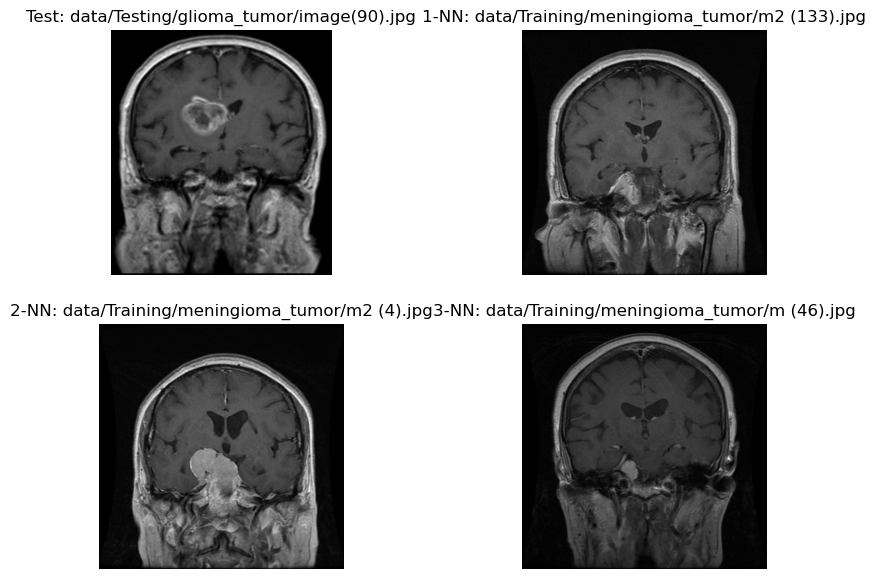

In [38]:
plot_test_result_with_3NN(random_row["image"], nn_filenames)

We can see that the images returned are similar in nature to the test image and are all the category of Meningioma.

Let's try another sample image and search for similar images.

In [39]:
# Get another row
random_row_index = 45

In [40]:
# Select the random row and the desired column's value
random_row = testing_embeddings_glioma.iloc[random_row_index]
sample_embedding = [random_row["vectors"]]

In [41]:
results = table.search(sample_embedding, n=3)

In [42]:
nn_filenames = results[0]["image"]

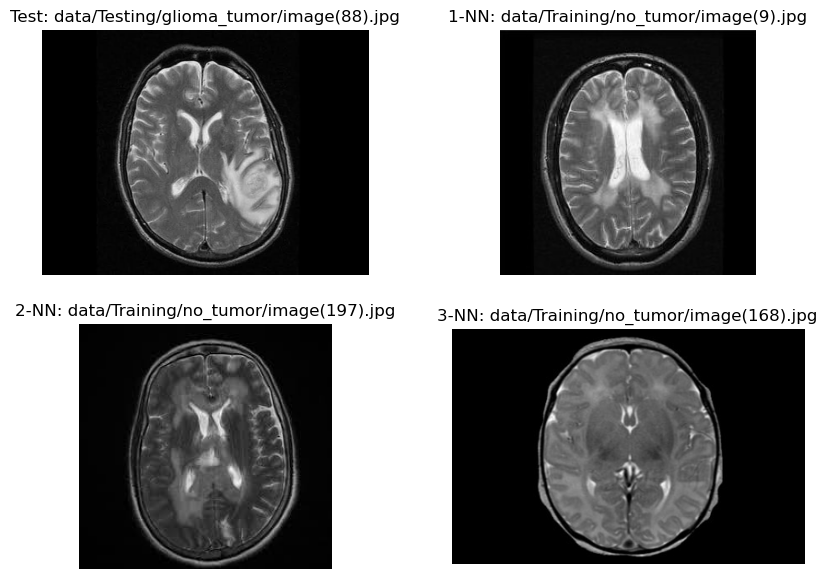

In [43]:
plot_test_result_with_3NN(random_row["image"], nn_filenames)

We can see with this second test image that we get a set of similar brain scans back that match the second test image closely and are all the category of no tumor. This kind of result can help a doctor confirm their own assumptions.

## 6. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [44]:
table.drop()

True